## 0. Executive Summary
- For this report, we anwsered the question: what factors impact clients choosing/selecting a tasker in the result page, we built the predictive the model to explore the relation between the features and tasker being hired or not.Based the resuls, we have extracted some insights as below:

- Top relevant variables are category, there are certain categories (like furniture assembly, moving help, etc) which are more relevant to the if tasker is hired or not. If login the website, Mounting, Furniture Assembly and Help moving are three categories show up in the main webpage under the search bar, it is natural for user to click in these three categories rather than clicking on "see more" to explore others.

- Position pf tasker in the recommendation list and hourly rate really matters, For position and hourly rate, based on the partial dependency plot, which show monotonically relationship with hired result. The higher the position, the more important, and the more likely to be hired for tasker, also the lower hourly rate, will increase the possibility to be hired

- Search time also really matters, which week/hout and day of week do user performed search, also affect the user decision to hire tasker or not.




In [ ]:
from google.colab import files
uploaded = files.upload()

Saving takehome_data.csv to takehome_data.csv


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import joblib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer, MultiLabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,precision_recall_curve,precision_score,auc,make_scorer,recall_score,accuracy_score
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras

In [ ]:
data = pd.read_csv('takehome_data.csv')

,funnel_search_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1013579273,5,29,39,0,Furniture Assembly


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   funnel_search_id     30000 non-null  object
 1   created_at           30000 non-null  object
 2   tasker_id            30000 non-null  int64 
 3   position             30000 non-null  int64 
 4   hourly_rate          30000 non-null  int64 
 5   num_completed_tasks  30000 non-null  int64 
 6   hired                30000 non-null  int64 
 7   category             30000 non-null  object
dtypes: int64(5), object(3)
memory usage: 1.8+ MB


## 1. Data preprocessing

In [ ]:
#y_train = data['IsBadBuy'].values


X_train, f_train = [], []

numerics_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_cols = data.select_dtypes(include=numerics_types).columns.tolist()
categorical_cols= data.select_dtypes(include=['object', 'category']).columns.tolist()
data['created_at'] =  pd.to_datetime(data['created_at'])


datetime_cols=data.select_dtypes(include=['datetime64']).columns.tolist()

### 1.1 Check unique records
-  funnel_search_id and tasker_id are not unique, that is reasonable, the data is organized by tasker_id, the same tasker may show up on the list for given a task multiple times, and funnel_search_id is a group of tasker_ids, if different tasker_id are displayed as a result of one result, they all belong to the one recommendation list.

In [ ]:
# Check if trip_id is unique in table
print ("number of unique tasker_id is: "+str(data['tasker_id'].nunique()))
print ("number of tasker_id is: "+str(data.shape[0]))

# Check if trip_id is unique in table
print ("number of unique funnel_search_id is: "+str(data['funnel_search_id'].nunique()))
print ("number of funnel_search_id is: "+str(data.shape[0]))


# if duplicated drop them and keep the last/first ones
data.drop_duplicates(inplace=True)
### 1.1 Check unique records

number of unique tasker_id is: 830
number of tasker_id is: 30000
number of unique funnel_search_id is: 2100
number of funnel_search_id is: 30000



###  1.2 Processing missing value:
- no missing value detected, that is good to see!


In [ ]:
pd.DataFrame({"Column names":data.isnull().sum().reset_index()['index'],"number of missing":data.isnull().sum().reset_index()[0],"percentage of missing":data.isnull().mean().reset_index()[0]})

,Column names,number of missing,percentage of missing
0,funnel_search_id,0,0.0
1,created_at,0,0.0
2,tasker_id,0,0.0
3,position,0,0.0
4,hourly_rate,0,0.0
5,num_completed_tasks,0,0.0
6,hired,0,0.0
7,category,0,0.0


### 1.3 Processing abnormal/invalid data
- in general, the data quality looks good, no negative values or extreme number occurs

In [ ]:
data.describe(include='all')

,funnel_search_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
count,30000,30000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000
unique,2100,1489,NaN,NaN,NaN,NaN,NaN,3
top,0-0-58024ee7-fb6d-4873-8e7d-b9eadcf29900,2017-09-10 14:27:00,NaN,NaN,NaN,NaN,NaN,Moving Help
freq,15,105,NaN,NaN,NaN,NaN,NaN,10000
first,NaN,2017-09-01 00:32:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-09-30 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.011072e+09,7.873600,57.482533,221.235700,0.056833,NaN
std,NaN,NaN,2.501822e+06,4.319442,36.222860,279.801812,0.231528,NaN
min,NaN,NaN,1.006647e+09,1.000000,18.000000,0.000000,0.000000,NaN
25%,NaN,NaN,1.008955e+09,4.000000,38.000000,23.000000,0.000000,NaN


## 2. Data Exploration
### 2.0 datetime features
- for time related features time of the search, we also extracted, year/week/month/day/hour/day of week to construct more features, hoping to capture and explore time related pattern about the search and if hired or not.

In [ ]:
for dateCol in datetime_cols:
  data[dateCol] = pd.to_datetime(data[dateCol],format = '%Y-%m-%dT%H:%M:%SZ',errors = 'coerce')
  #print(data[dateCol])

  data[str(dateCol)+'_year'] = data[dateCol].dt.year
  data[str(dateCol)+'_month'] = data[dateCol].dt.month
  data[str(dateCol)+'_week'] = data[dateCol].dt.week
  data[str(dateCol)+'_day'] = data[dateCol].dt.day
  data[str(dateCol)+'_hour'] = data[dateCol].dt.hour
  data[str(dateCol)+'_minute'] = data[dateCol].dt.minute
  data[str(dateCol)+'_dayofweek'] = data[dateCol].dt.dayofweek

  #print(str(dateCol)+"_year")
  datetime_list=[str(dateCol)+"_year",str(dateCol)+"_month",str(dateCol)+"_week",str(dateCol)+"_day",str(dateCol)+"_hour",str(dateCol)+"_minute",str(dateCol)+"_dayofweek"]
  
  #standarization
  #sc_scale = preprocessing.StandardScaler().fit(data[datetime_list])
  #data[datetime_list] = sc_scale.transform(data[datetime_list])

  X_time=data[datetime_list] 

 
  f_train+=datetime_list
 



### 2.1 Numerical features
-  position is more like uniform evenly distributed
-  for hourly rate and num_completed_tasks features, their distribution are right skewed

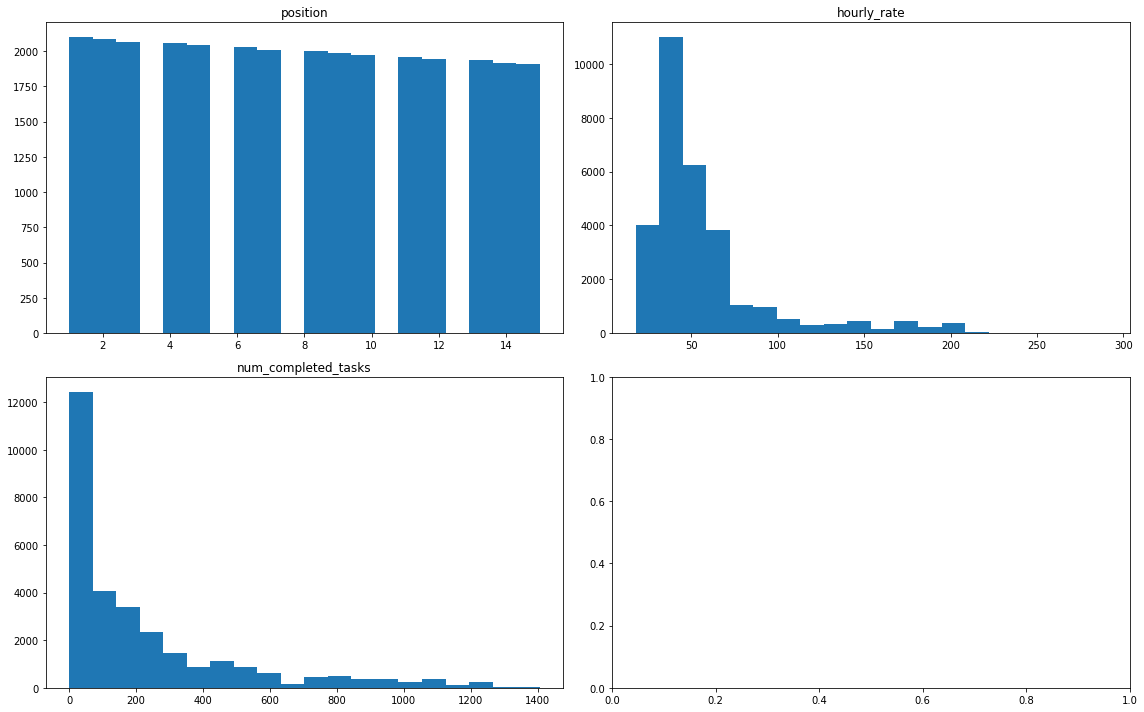

In [ ]:
# numerical features
numerical_fs=['position', 'hourly_rate', 'num_completed_tasks']
fig,ax = plt.subplots(2,2, figsize = (16,10))
for i, col in enumerate(numerical_fs):
    ax[i//2, i%2].hist(data[col],bins = 20)
    ax[i//2, i%2].set_title(col)


fig.tight_layout()

Looks like no strong correlations exists between features

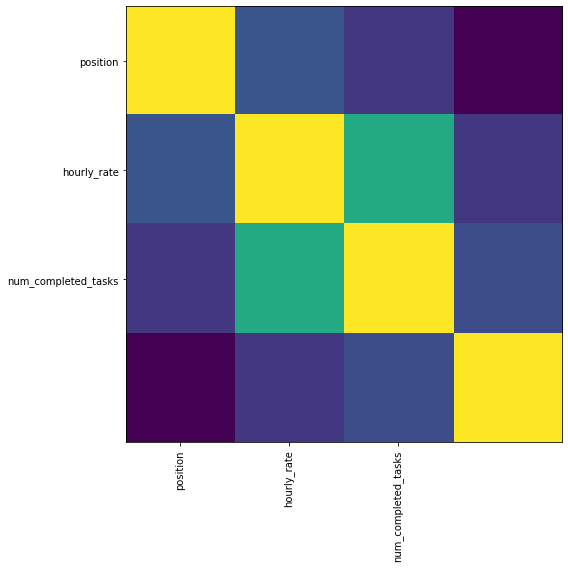

In [ ]:
numerical_cols.append('hired')
X = data[['position', 'hourly_rate', 'num_completed_tasks','hired']]
yj_scaler = PowerTransformer()
X = yj_scaler.fit_transform(X)

fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(np.corrcoef(np.nan_to_num(X,0).T))
ax.set_yticks(range(len(numerical_fs)))
ax.set_yticklabels(numerical_fs)
ax.set_xticks(range(len(numerical_fs)))
ax.set_xticklabels(numerical_fs,rotation = 90)
fig.tight_layout()

In [ ]:
f_train += numerical_fs

### 2.2 Categorical features
- For categorical feature "category", we encode it based on one-hot encoding to convert the numerical vector


In [ ]:
dense_cols = ['category']

# One-hot encoding
df_dense = pd.get_dummies(data[dense_cols])

# append features
# X_train.append(df_dense.values)
f_train += list(df_dense.columns)

dense_cols_encoded = df_dense.columns

print(f'Number of Encoded Categorical Dense features: {len(dense_cols_encoded)}')

Number of Encoded Categorical Dense features: 3


In [ ]:
# Check if trip_id is unique in table
print ("number of unique tasker_id is: "+str(data['tasker_id'].nunique()))
print ("number of tasker_id is: "+str(data.shape[0]))

# if duplicated drop them and keep the last/first ones
data.drop_duplicates(inplace=True)
### 1.1 Check unique records

number of unique tasker_id is: 830
number of tasker_id is: 30000


### 2.3 Data preparation

In [ ]:
# Concat all features created
X_train=np.hstack((X_time.values,data[numerical_fs],df_dense)) 
y_train = data['hired'].values


## 4.  Model building and evaluation

#### 4.1 SMOTE + Random Forest + cross validation 

-  target variable (hired) is highly imbalanced,We use SMOTE technique to over-sample the minority classes and create synthetic data through nearest neighbor. The SMOTE technique increase the robustness of training under imbalanced data.

- The classifier we choose is random forest because we anticipated strong non-linear data structure. We choose 200 estimators and tune the paramter of max tree depth by 5-fold stratified cross validation. The cross validated F1 score and Precision-Recall AUC is given.

- Also the Precision-Recall curve of validation data during each runing is also plotted.

In [ ]:
data['hired'].value_counts()

0    28295
1     1705
Name: hired, dtype: int64

max_depth = 3,  CV ROC-AUC: 0.2424,CV PR-AUC: 0.2081, Max F1 score: 0.2819
max_depth = 6,  CV ROC-AUC: 0.2174,CV PR-AUC: 0.2158, Max F1 score: 0.3150
max_depth = 9,  CV ROC-AUC: 0.2322,CV PR-AUC: 0.2090, Max F1 score: 0.3046
max_depth = 12,  CV ROC-AUC: 0.2496,CV PR-AUC: 0.1962, Max F1 score: 0.2865
max_depth = 15,  CV ROC-AUC: 0.2799,CV PR-AUC: 0.1731, Max F1 score: 0.2591


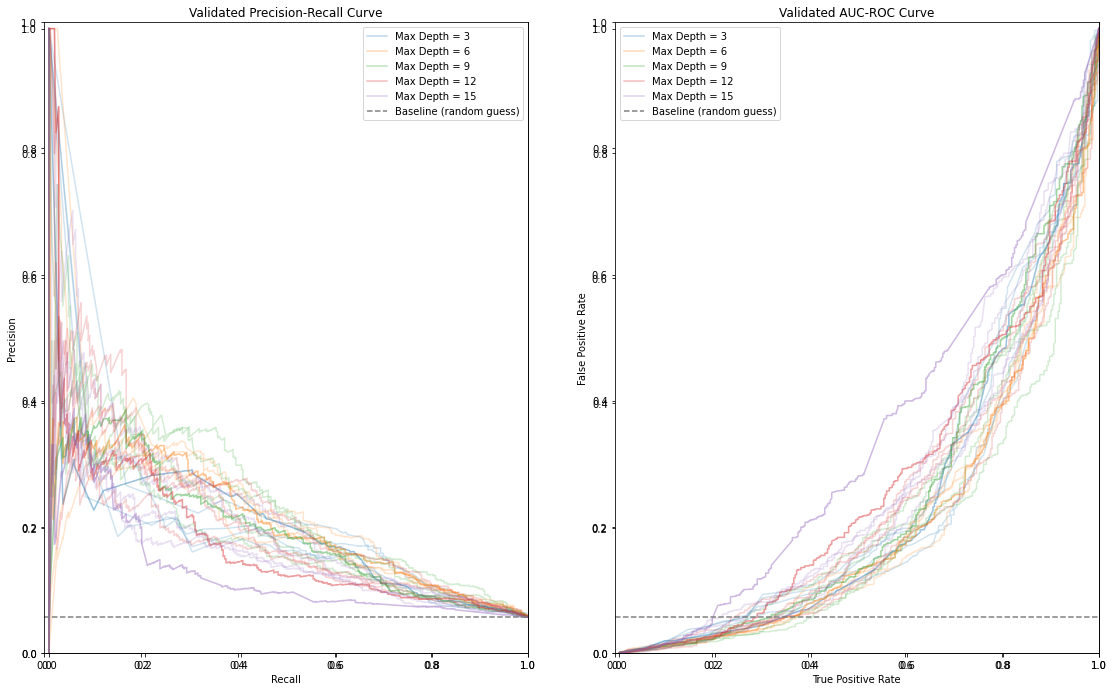

In [ ]:
from sklearn import metrics

f1_cv,auc_cv, roc_auc_cv = [], [], []

# Stratified k-fold validation
skf = StratifiedKFold(n_splits = 5)
fig,ax = plt.subplots(1,2,figsize = (16,10))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

colors = ['tab:blue','tab:orange', 'tab:green','tab:red','tab:purple']
for i, k in enumerate(range(3,16,3)):
    # Cross validation
    f1,pr_auc,roc_auc = [],[],[]
    for t_idx, v_idx in skf.split(X_train,y_train):
        # Resample with SMOTE
        sm = SMOTE(random_state=42,n_jobs = 8)
        X_res, y_res = sm.fit_resample(X_train[t_idx,:], y_train[t_idx])
        
        # train with random foreset
        clf = RandomForestClassifier(n_estimators = 10,max_depth=k,n_jobs = 8)
        # here need to recalibrated on prediction
        clf.fit(X_res, y_res)
        
        #clf_nonsmote = RandomForestClassifier(n_estimators = 10,max_depth=k,n_jobs = 8)
        #clf_nonsmote.fit(X_train[t_idx,:], y_train[t_idx])
        
        # Evaluate by F1 and precision-recall curve AUC
        y_pred = clf.predict_proba(X_train[v_idx,:])
        prc, rcl, _ = precision_recall_curve(y_train[v_idx],y_pred[:,1])
        # Evalaute by AUC ROC curve

        #y_pred = clf_nonsmote.predict_proba(X_train[v_idx,:])
        fpr, tpr, _ = roc_curve(y_train[v_idx],y_pred[:,1])
        
        #print(sum(y_train[v_idx]))
        '''
        print('iteration 1 start')
        print(y_pred)
        print(fpr)
        print(tpr)
        print(thresholds)
        print('iteration 1 end')
        '''
        # Plot Precsion-recall curve and AUC-ROC curve
        ax1.plot(rcl,prc,color = colors[i], alpha = 0.2)
        ax2.plot(tpr,fpr,color = colors[i], alpha = 0.2)

        f1.append((2*prc*rcl/(prc + rcl+1e-6)).max())
        pr_auc.append(auc(rcl, prc))
        roc_auc.append(auc(tpr,fpr))


    ax1.plot(rcl,prc,color = colors[i], alpha = 0.3,label = f'Max Depth = {k}')
    ax2.plot(tpr,fpr,color = colors[i], alpha = 0.3,label = f'Max Depth = {k}')
    

    #calculate average score
    f1_cv.append(np.mean(f1))
    auc_cv.append(np.mean(pr_auc))
    roc_auc_cv.append(np.mean(roc_auc))
    
    print(f'max_depth = {k},  CV ROC-AUC: {np.mean(roc_auc):.4f},CV PR-AUC: {np.mean(pr_auc):.4f}, Max F1 score: {np.mean(f1):.4f}')
    
# Plots
ax1.axhline(y_train.mean(),linestyle = '--',color = 'gray',label='Baseline (random guess)')
ax1.set_title('Validated Precision-Recall Curve')
ax1.set_xlim([-0.01,1])
ax1.set_ylim([0,1.01])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()


ax2.axhline(y_train.mean(),linestyle = '--',color = 'gray',label='Baseline (random guess)')
ax2.set_title('Validated AUC-ROC Curve')
ax2.set_xlim([-0.01,1])
ax2.set_ylim([0,1.01])
ax2.set_xlabel('True Positive Rate')
ax2.set_ylabel('False Positive Rate')

ax2.legend()


fig.tight_layout()

##5. Feature importance
### 5.1 feature importance
- looks like the top relevant variables are category, there are certain categories (like furniture assembly, moving help, etc) which are more relevant to the if tasker is hired or not. If login the website, Mounting, Furniture Assembly and Help moving are three categories show un in the main webpage under the search bar, it is natural for user to click in these three categories rather than clicking on "see more" to explore others.
- search time also really matters, which week/hout and day of week do user performed search, also affect the user decision to hire tasker or not.

- position and hourly rate are also important features, it is reasonable to think higher position of tasker in the recommendation list will get more impression, therefore increasing the probability being hired. we will deep dive next parts exploring the relation position/hourly rate vs hire or not

In [ ]:
# feature importance
f_importance = pd.DataFrame()
f_importance['Feature'] = f_train
f_importance['Importance'] = clf.feature_importances_
topkfeatures=f_importance.sort_values('Importance',ascending=False).reset_index(drop =True).head(15)
topkfeatures

,Feature,Importance
0,category_Furniture Assembly,0.357874
1,category_Moving Help,0.142693
2,created_at_week,0.100568
3,category_Mounting,0.083809
4,created_at_hour,0.066712
5,created_at_dayofweek,0.066551
6,created_at_day,0.058063
7,created_at_minute,0.048770
8,num_completed_tasks,0.026801
9,position,0.024808


###### Below is feature importance plot, regardless of the actual accuracy of this specific variable importance technique, what is much more important is that a plot like this one above is not really that informative. we will care about a statement like: “the time of the day in which hired/no hired likelihood is important!”. What they want to know is when is the best time, and variable importance gives no info about it. So we adapt to the partial dependency plot to extract some insights

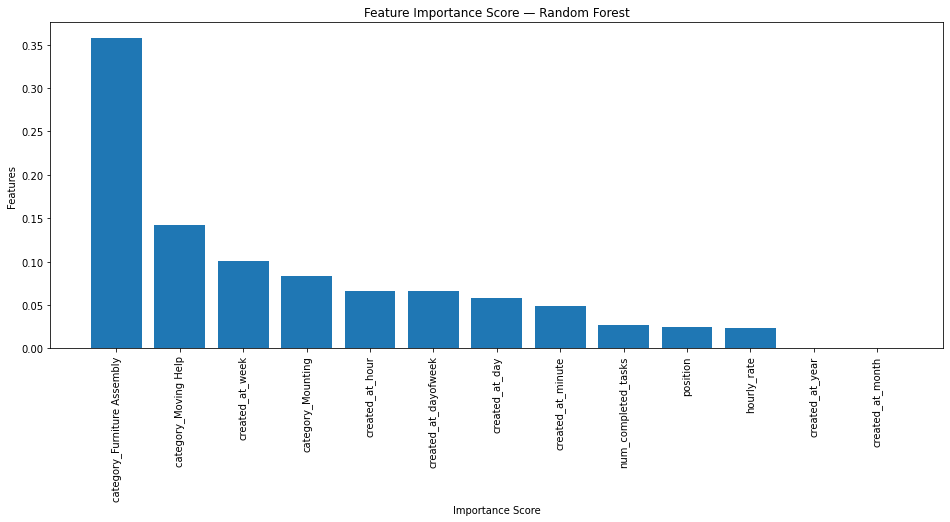

In [ ]:
plt.figure(figsize=(16,6))

plt.bar(topkfeatures['Feature'],topkfeatures['Importance'])
plt.xticks(rotation=90)

plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Random Forest')


plt.show()

### 5.2 Partial Dependency plot analysis
- Firstly, look at the y-axis scale. The larger that scale, the more important is that variable. It’s essentially telling us by how much changing that variable value would impact the output. And our goal is finding where the change is the largest.
- For position and hourly rate, the plot show monotonically relationship with output. The higher the position, the more important, and the more likely to be hired for tasker, also the lower hourly rate, will increase the possibility to be hired!




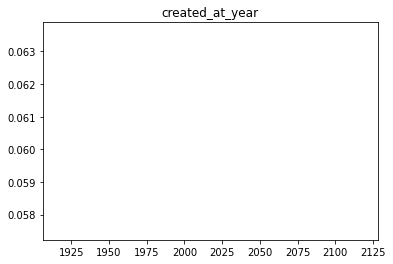

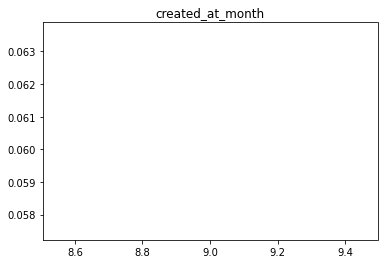

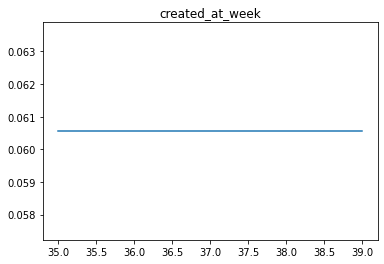

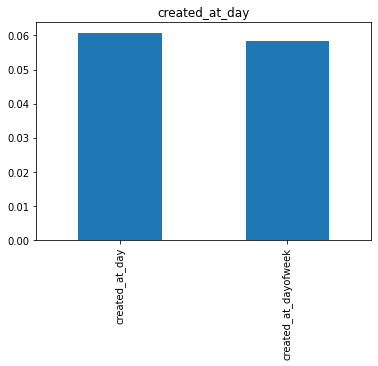

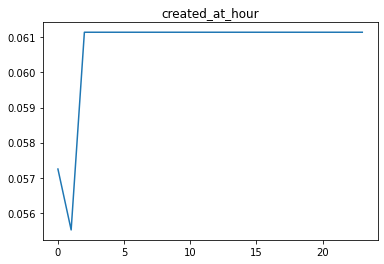

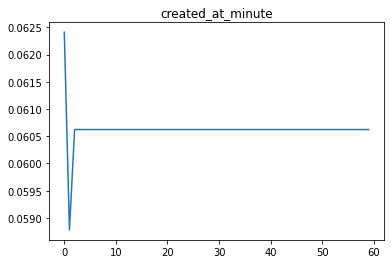

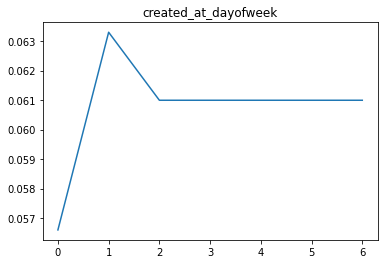

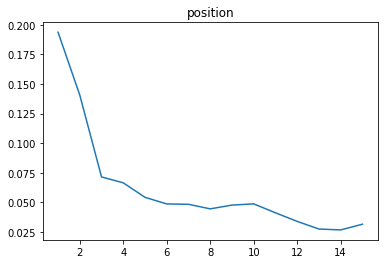

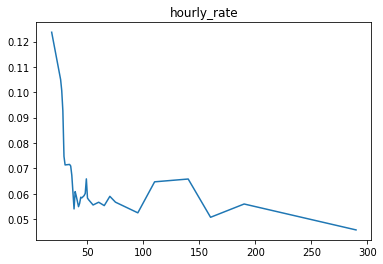

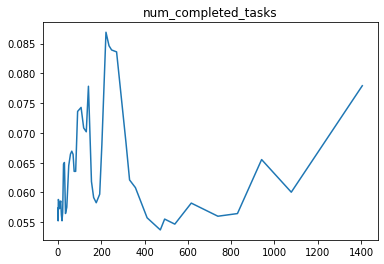

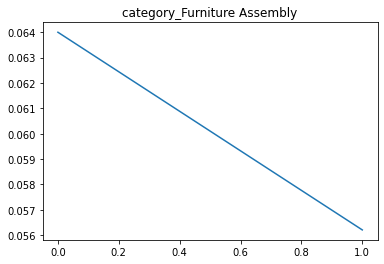

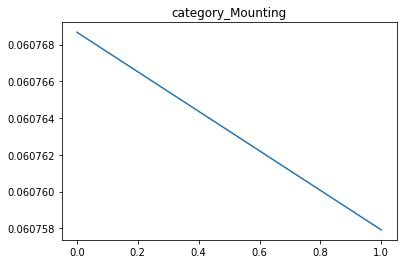

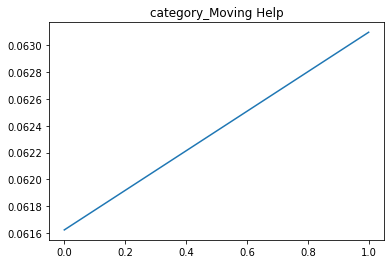

In [ ]:
agg_data=pd.concat([X_time,data[numerical_fs],df_dense],axis=1)

rf = RandomForestClassifier(class_weight={0:0.05,1:0.95}, n_estimators=50)
rf.fit(train_cols, data_dummy['hired'])
  
#Let's plot all of them. Note that pdpbox allows to group together dummy variables coming from the same categorical variable. For this we need to get the original variable names.
feat_original = f_train
train_cols=agg_data

#plot all variables with a for loop. If a variable is categorical make sure to plot all levels together.
for i in range(len(feat_original)):
    #get all variables that include the name in feat_original. So, if it is numeric, just take that variable. If it is categorical, take all dummies belonging to the same categorical variable. Since for dummies their name is variable_level, this is easy. Just pick all variables that start with the original variable name. I.e. to get all weekday dummies (weekday_Monday, weekday_Tuesday, etc.), we just look for all variables starting with "weekday"
    #variables to plot
    plot_variable = [e for e in list(train_cols) if e.startswith(feat_original[i])]
      
    #numeric variables or dummy with just 1 level
    if len(plot_variable) == 1:
       pdp_iso = pdp.pdp_isolate( model=rf, dataset=train_cols, model_features=list(train_cols), feature=plot_variable[0], num_grid_points=50)
       pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
       #pdpbox has several options if you want to use their built-in plots. I personally prefer just using .plot. It is totally subjective obviously.
       pdp_dataset.plot(title=feat_original[i])
       plt.show()
         
    #categorical variables with several levels
    else:
       pdp_iso = pdp.pdp_isolate( model=rf, dataset=train_cols, model_features=list(train_cols),  feature=plot_variable, num_grid_points=50)
       pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
       pdp_dataset.sort_values(ascending=False).plot(kind='bar', title=feat_original[i])
       plt.show()
    plt.close()   